In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
random.seed(10)

In [2]:
df = pd.read_csv('SJ001_merge_1day_full.csv')
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

g_avg = np.zeros((12, 97))

for i in range(12):
    group = df[(df.DATE >= 0+30*i) & (df.DATE <= 30+30*i)].groupby('DATE')
    group = group.filter(lambda x: x['GEN_ENERGY'].mean() >= 100)
    g_avg[i,:] = group.groupby('TIME').mean()['GEN_ENERGY'].values

date = data[:,0]
time = data[:,1]

d=(date/31).astype('int')
t = ((time-5)*6.01).astype('int')

df['avg'] = g_avg[d,t]
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [3]:
df.head()

,SITE_NO,DATE,TIME,GEN_ENERGY,TEMPERATURE,SOLAR_IRRADIANCE,WIND_SPEED,MODULE_TEMPERATURE,POP,REH,SKY,T3H,WSD,avg
0,SJ001,245,5.000000,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,106.119545
1,SJ001,245,5.166667,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,87.138636
2,SJ001,245,5.333333,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,87.138636
3,SJ001,245,5.500000,0.0,0.00,0.0,0.0,0.0000,10.0,50.0,2.0,25.0,1.4,87.138636
4,SJ001,245,5.666667,0.0,14.82,0.0,0.0,13.3729,10.0,50.0,2.0,25.0,1.4,87.138636


In [4]:
train_day = 400
test_day = 50

interval = 97
input_size = 8
# input_size = 9

train_num = 97* train_day
test_num = 97* test_day

input_series = np.zeros((train_num + test_num, interval, input_size))
target_series = np.zeros((train_num + test_num, interval, input_size))

for i in range(train_num + test_num):
    input_series[i, :, 0] = data[i: i+interval, 2]
    input_series[i, :, 1:3] = data[i: i+interval, 0:2]
    input_series[i, :, 3:8] = data[i: i+interval, -5:]
#     input_series[i, :, 3:9] = data[i: i+interval, -6:]
    
    target_series[i, :, 0] = data[i+interval: i+interval*2, 2]
    target_series[i, :, 1:3] = data[i+interval: i+interval*2, 0:2]
    target_series[i, :, 3:8] = data[i+interval: i+interval*2, -5:]
#     target_series[i, :, 3:9] = data[i+interval: i+interval*2, -6:]

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)
    
X_train = input_series[:train_num]
X_test = input_series[train_num: train_num + test_num]
y_train = target_series[:train_num]
y_test = target_series[train_num: train_num + test_num]

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        batch_size, seq_len = input.shape[0], input.shape[1]
        output = input.float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(DecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.shape[0]
        output = input.view(batch_size, 1, self.input_size).float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        
        return output, hidden    

In [13]:
hidden_size = 512
encoder1 = EncoderRNN(input_size, hidden_size).to(device)
decoder1 = DecoderRNN(input_size, hidden_size, 1).to(device)

In [14]:
teacher_forcing_ratio = 0.5
max_grad_norm = 1

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size = batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)


    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = input_tensor[:, -1:, :]
    decoder_hidden = encoder_hidden
    outputs = []
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
#     outputs, _ = decoder(decoder_input, decoder_hidden, target_length)

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = target_tensor[:, di:di+1, :] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input 
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = torch.cat([decoder_output, target_tensor[:, di:di+1, 1:].float()], dim=2)
            
        
    outputs = torch.stack(outputs, dim=1).view(batch_size, target_length, 1)
#     loss += criterion(decoder_output, target_tensor.float())
    loss = criterion(outputs, target_tensor[:, :, 0:1].float())

    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_grad_norm)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_grad_norm)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [15]:
def trainIters(encoder, decoder, batch_size = 50, epoch = 100, n_iters=train_num, print_every=1000, plot_every=100, learning_rate=0.005):
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for ep in range(epoch):
        loss = 0
        
        for b in range(int(train_num / batch_size)):
            input_tensor = input_series[batch_size*b:batch_size*(b+1)]
            target_tensor = target_series[batch_size*b:batch_size*(b+1)]

            loss += train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss = loss/ int(train_num / batch_size)    
        plot_losses.append(loss)
        print("Epoch ", ep, "MSE: ", loss*100)

In [16]:
trainIters(encoder1, decoder1, epoch=50)

Epoch  0 MSE:  0.02276604973292017
Epoch  1 MSE:  0.012425049793305363
Epoch  2 MSE:  0.011381647547132171
Epoch  3 MSE:  0.010947240625253568
Epoch  4 MSE:  0.01056367857915122
Epoch  5 MSE:  0.010262746662154614
Epoch  6 MSE:  0.010121097520582547
Epoch  7 MSE:  0.009924502328644742
Epoch  8 MSE:  0.21843805793567367
Epoch  9 MSE:  0.12706547802643173
Epoch  10 MSE:  0.0840682523743385
Epoch  11 MSE:  0.08753798575579429
Epoch  12 MSE:  0.0886946407540008
Epoch  13 MSE:  0.06784836910206998
Epoch  14 MSE:  0.06807768030509519
Epoch  15 MSE:  0.06602378632153554
Epoch  16 MSE:  0.058517292090468534
Epoch  17 MSE:  0.0616518280522257
Epoch  18 MSE:  0.054404125162930854
Epoch  19 MSE:  0.051210838291854036
Epoch  20 MSE:  0.058386549291921316
Epoch  21 MSE:  0.06352523591209826
Epoch  22 MSE:  0.06235079397876744
Epoch  23 MSE:  0.06624343883334664
Epoch  24 MSE:  0.05520752161847507
Epoch  25 MSE:  0.0610272090786842
Epoch  26 MSE:  0.05135563734101192
Epoch  27 MSE:  0.04340355815031

In [17]:
def evaluate(encoder, decoder, input_tensor, target_tensor, target_length):
    with torch.no_grad():
        input_tensor = input_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size = 1)

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = input_tensor[:, -1:, :] 
        decoder_hidden = encoder_hidden
        
        decoded = []
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoded.append(decoder_output.item())
            decoder_input = torch.cat([decoder_output, target_tensor[:, di:di+1, 1:].float()], dim=2)
            
        return decoded

In [18]:
# hidden = 512 (reference)

predicted = torch.zeros(interval * (train_day + test_day)).to(device)
for i in range(train_day + test_day):
    dec = evaluate(encoder1, decoder1, input_series[interval*i], target_series[interval*i], interval)
    predicted[interval*i: interval*(i+1)] = torch.Tensor(dec)


loss = nn.MSELoss()
whole_data = torch.from_numpy(data[interval:interval + interval*(train_day + test_day),2]).to(device).float()
train_loss = loss(predicted[:interval*train_day], whole_data[:interval*train_day])
test_loss = loss(predicted[interval*train_day: interval*(train_day+test_day)], whole_data[interval*train_day: interval*(train_day+test_day)])
print("train_loss : %f" %(train_loss))
print("test_loss : %f" %(test_loss))

train_loss : 0.022964
test_loss : 0.020091


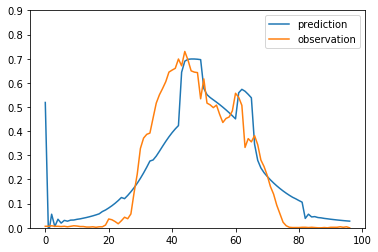

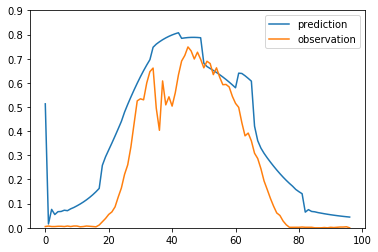

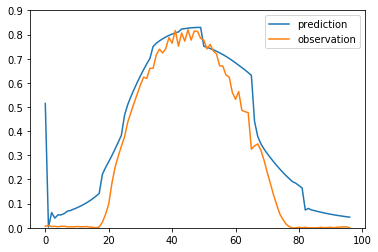

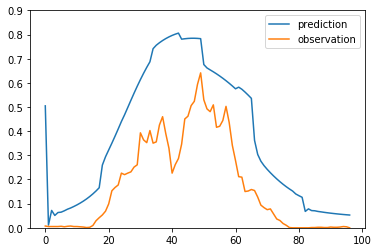

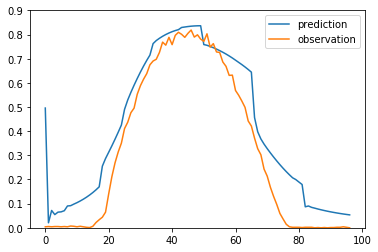

In [19]:
# Test data = 401~
index = 401
for i in range(5):
    dec = evaluate(encoder1, decoder1, input_series[interval*index + interval*i], target_series[interval*index + interval*i], interval)
    plt.plot(dec, label = 'prediction')
    plt.plot(target_series[interval*index + interval*i, :, 0].cpu().numpy(), label = 'observation')
    plt.ylim([0,0.9])
    plt.legend()
    plt.show()

In [15]:
# hidden = 512

predicted = torch.zeros(interval * (train_day + test_day)).to(device)
for i in range(train_day + test_day):
    dec = evaluate(encoder1, decoder1, input_series[interval*i], target_series[interval*i], interval)
    predicted[interval*i: interval*(i+1)] = torch.Tensor(dec)


loss = nn.MSELoss()
whole_data = torch.from_numpy(data[interval:interval + interval*(train_day + test_day),2]).to(device).float()
train_loss = loss(predicted[:interval*train_day], whole_data[:interval*train_day])
test_loss = loss(predicted[interval*train_day: interval*(train_day+test_day)], whole_data[interval*train_day: interval*(train_day+test_day)])
print("train_loss : %f" %(train_loss))
print("test_loss : %f" %(test_loss))

train_loss : 0.031276
test_loss : 0.015605


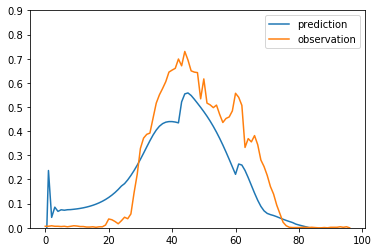

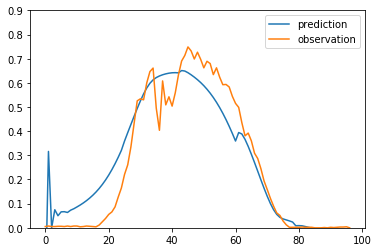

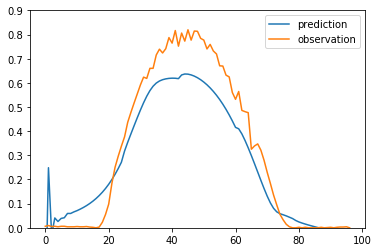

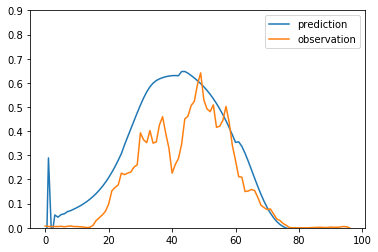

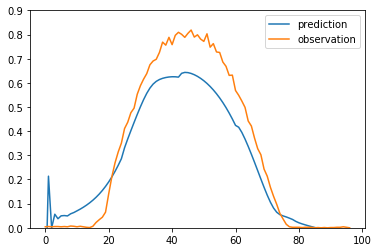

In [16]:
# Test data = 401~
index = 401
for i in range(5):
    dec = evaluate(encoder1, decoder1, input_series[interval*index + interval*i], target_series[interval*index + interval*i], interval)
    plt.plot(dec, label = 'prediction')
    plt.plot(target_series[interval*index + interval*i, :, 0].cpu().numpy(), label = 'observation')
    plt.ylim([0,0.9])
    plt.legend()
    plt.show()